# Stack Overflow: Tag Prediction

<h2> 1. Problem Statemtent </h2>
Predicting the tags based on the content in the question and description posted on StackOverflow

**Why tags** :
Based on tags ,stackoverflow sends the questions to concerned persons who have answered similar questions in the past

 <h2> 1.1 Real World / Business Objectives and Constraints </h2>

1. Predict as many tags as possible with high precision and recall.
2. Incorrect tags could impact customer experience on StackOverflow.
3. No strict latency constraints,can take couple of minutes to predict the tags

<h2>1.2 Data-Overview </h2>

__Data Field Explaination__

Dataset contains 6,034,195 rows. The columns in the table are:<br />
<pre>
<b>Id</b> - Unique identifier for each question<br />
<b>Title</b> - The question's title<br />
<b>Body</b> - The body of the question<br />
<b>Tags</b> - The tags associated with the question in a space-seperated format (all lowercase, should not contain tabs '\t' or ampersands '&')<br />
</pre>

<br />


<h2>1.3 Mapping the real-world problem to a Machine Learning Problem </h2>

<p> It is a multi-label classification problem  <br>

<h3>Performance metric </h3>
<b>Micro-Averaged F1-Score (Mean F Score) </b>: 
The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is:

<i>F1 = 2 * (precision * recall) / (precision + recall)</i><br>

In the multi-class and multi-label case, this is the weighted average of the F1 score of each class. Micro-Averaged F1-Score takes class-imbalance into consideration.It gives more weightage to the frequency of occurence of tags<br>

<b>'Micro f1 score': </b><br>
Calculate metrics globally by counting the total true positives, false negatives and false positives. This is a better metric when we have class imbalance.

<b> Hamming loss </b>: In simplest of terms, Hamming-Loss is the fraction of labels that are incorrectly predicted, i.e., the fraction of the wrong labels to the total number of labels.. <br>


**Note** : Here we are taking only 500000 data-points for this assignment with more weightage for the feature "Title" and using only top-500 tags for building classification models

<h1> 2. Exploratory Data Analysis </h1>

In [1]:
#importing required libraries
#importing required libraries
%matplotlib inline
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
import warnings
warnings.filterwarnings("ignore")
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import re
import os
import csv
import sqlite3
import numpy as np
import pandas as pd
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sqlalchemy import create_engine #used to create database connection
from datetime import datetime
import datetime as dt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer #bag of words
from sklearn.feature_extraction.text import TfidfVectorizer #tfidf vectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from prettytable import PrettyTable

<h2> 2.1 Data Loading and Cleaning </h2>

<h3>2.1.1 Using Pandas with SQLite to Load the data</h3>

In [3]:
#Creating db file from csv which is useful when we have large database
if not os.path.isfile('train.db'):
    start = datetime.now()
    disk_engine = create_engine('sqlite:///train.db')
    start = dt.datetime.now()
    chunksize = 180000
    j = 0
    index_start = 1
    for df in pd.read_csv('Train.csv', names=['Id', 'Title', 'Body', 'Tags'], chunksize=chunksize, iterator=True, encoding='utf-8', ):
        df.index += index_start
        j+=1
        print('{} rows'.format(j*chunksize))
        df.to_sql('data', disk_engine, if_exists='append')
        index_start = df.index[-1] + 1
    print("Time taken to run this cell :", datetime.now() - start)

<h3> 2.1.2 Counting the number of rows </h3>

In [4]:
#getting the number of rows in the database we created previously
#starting the sql connection
if os.path.isfile('train.db'):
    start = datetime.now()
    con = sqlite3.connect('train.db')
    num_rows = pd.read_sql_query("""SELECT count(*) FROM data""", con)
    #Always remember to close the database
    print("Number of rows in the database :","\n",num_rows['count(*)'].values[0])
    con.close()
    print("Time taken to count the number of rows :", datetime.now() - start)
else:
    print("create one")

Number of rows in the database : 
 6034196
Time taken to count the number of rows : 0:01:15.750352


<h3>2.1.3 Checking for duplicates </h3>

In [5]:
#checking for duplicates present in data
if os.path.isfile('train.db'):
    start = datetime.now()
    con = sqlite3.connect('train.db')
    df_no_dup = pd.read_sql_query('SELECT Title, Body, Tags, COUNT(*) as cnt_dup FROM data GROUP BY Title, Body, Tags', con)
    con.close()
    print("Time taken to run this cell :", datetime.now() - start)
else:
    print("create one")

Time taken to run this cell : 0:04:33.560122


In [6]:
# number of times each question appeared in our database
df_no_dup.head()

,Title,Body,Tags,cnt_dup
0,Implementing Boundary Value Analysis of S...,<pre><code>#include&lt;iostream&gt;\n#include&...,c++ c,1
1,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding,1
2,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding columns,1
3,java.lang.NoClassDefFoundError: javax/serv...,"<p>I followed the guide in <a href=""http://sta...",jsp jstl,1
4,java.sql.SQLException:[Microsoft][ODBC Dri...,<p>I use the following code</p>\n\n<pre><code>...,java jdbc,2


In [7]:
print("number of duplicate questions :", num_rows['count(*)'].values[0]- df_no_dup.shape[0], "(",(1-((df_no_dup.shape[0])/(num_rows['count(*)'].values[0])))*100,"% )")

number of duplicate questions : 1827881 ( 30.2920389063 % )


In [8]:
# number of times each question appeared in our database
df_no_dup.cnt_dup.value_counts()

1    2656284
2    1272336
3     277575
4         90
5         25
6          5
Name: cnt_dup, dtype: int64

<h3>2.1.4 Counting the number of tags in each data-point </h3>

In [9]:
#getting the nuber of tags in each data-point
start = datetime.now()
df_no_dup["tag_count"] = df_no_dup["Tags"].apply(lambda text: len(text.split(" ")))
# adding a new feature number of tags per question
print("Time taken to run this cell :", datetime.now() - start)
df_no_dup.head()

Time taken to run this cell : 0:00:03.169523


,Title,Body,Tags,cnt_dup,tag_count
0,Implementing Boundary Value Analysis of S...,<pre><code>#include&lt;iostream&gt;\n#include&...,c++ c,1,2
1,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding,1,3
2,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding columns,1,4
3,java.lang.NoClassDefFoundError: javax/serv...,"<p>I followed the guide in <a href=""http://sta...",jsp jstl,1,2
4,java.sql.SQLException:[Microsoft][ODBC Dri...,<p>I use the following code</p>\n\n<pre><code>...,java jdbc,2,2


In [10]:
# distribution of number of tags per question
df_no_dup.tag_count.value_counts()

3    1206157
2    1111706
4     814996
1     568298
5     505158
Name: tag_count, dtype: int64

In [11]:
#Creating a new database with no duplicates
if not os.path.isfile('train_no_dup.db'):
    disk_dup = create_engine("sqlite:///train_no_dup.db")
    no_dup = pd.DataFrame(df_no_dup, columns=['Title', 'Body', 'Tags'])
    no_dup.to_sql('no_dup_train',disk_dup)

In [12]:
#This method seems more appropriate to work with this much data.
#creating the connection with database file.
if os.path.isfile('train_no_dup.db'):
    start = datetime.now()
    con = sqlite3.connect('train_no_dup.db')
    tag_data = pd.read_sql_query("""SELECT Tags FROM no_dup_train""", con)
    #Always remember to close the database
    con.close()
     # Let's now drop unwanted column.
    tag_data.drop(tag_data.index[0], inplace=True)
    #Printing first 5 columns from our data frame
    tag_data.head()
    print("Time taken to run this cell :", datetime.now() - start)
else:
    print("create one")

Time taken to run this cell : 0:00:52.992676


<h2> 3.Univariate Analysis of Tags </h2>

<h3>3.1 Counting the number of tags in each data-point </h3>

In [13]:
#bag of words of tags
vectorizer = CountVectorizer(tokenizer = lambda x: x.split())
#fitting the vectorizer
tag_dtm = vectorizer.fit_transform(tag_data['Tags'])

In [14]:
print("Number of data points :", tag_dtm.shape[0])
print("Number of unique tags :", tag_dtm.shape[1])

Number of data points : 4206314
Number of unique tags : 42048


In [15]:
#'get_feature_name()' gives us the vocabulary.
tags = vectorizer.get_feature_names()
#Lets look at the tags we have.
print("Some of the tags we have :", tags[:10])

Some of the tages we have : ['.a', '.app', '.asp.net-mvc', '.aspxauth', '.bash-profile', '.class-file', '.cs-file', '.doc', '.drv', '.ds-store']


<h3>3.2 Frequency of each Tag in Data </h3>

In [16]:
#Lets now store the document term matrix in a dictionary.
freqs = tag_dtm.sum(axis=0).A1
result = dict(zip(tags, freqs))

In [17]:
#Saving this dictionary to csv files.
if not os.path.isfile('tag_counts_dict_dtm.csv'):
    with open('tag_counts_dict_dtm.csv', 'w') as csv_file:
        writer = csv.writer(csv_file)
        for key, value in result.items():
            writer.writerow([key, value])
tag_df = pd.read_csv("tag_counts_dict_dtm.csv", names=['Tags', 'Counts'])
tag_df.head()

,Tags,Counts
0,.a,18
1,.app,37
2,.asp.net-mvc,1
3,.aspxauth,21
4,.bash-profile,138


In [18]:
tag_df_sorted = tag_df.sort_values(['Counts'], ascending=False)
tag_counts = tag_df_sorted['Counts'].values

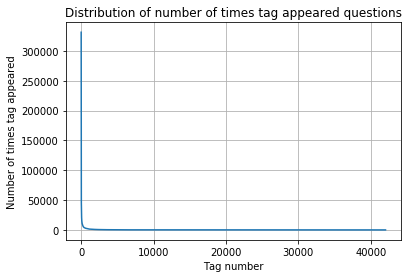

In [19]:
plt.plot(tag_counts)
plt.title("Distribution of number of times tag appeared questions")
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()

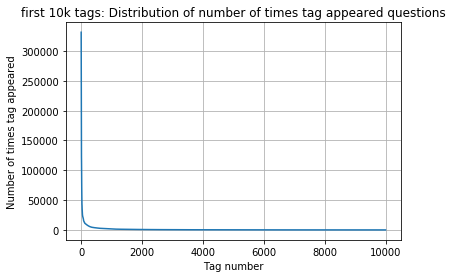

400 [331505  44829  22429  17728  13364  11162  10029   9148   8054   7151
   6466   5865   5370   4983   4526   4281   4144   3929   3750   3593
   3453   3299   3123   2989   2891   2738   2647   2527   2431   2331
   2259   2186   2097   2020   1959   1900   1828   1770   1723   1673
   1631   1574   1532   1479   1448   1406   1365   1328   1300   1266
   1245   1222   1197   1181   1158   1139   1121   1101   1076   1056
   1038   1023   1006    983    966    952    938    926    911    891
    882    869    856    841    830    816    804    789    779    770
    752    743    733    725    712    702    688    678    671    658
    650    643    634    627    616    607    598    589    583    577
    568    559    552    545    540    533    526    518    512    506
    500    495    490    485    480    477    469    465    457    450
    447    442    437    432    426    422    418    413    408    403
    398    393    388    385    381    378    374    370    367    365
  

In [20]:
plt.plot(tag_counts[0:10000])
plt.title('first 10k tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()
print(len(tag_counts[0:10000:25]), tag_counts[0:10000:25])

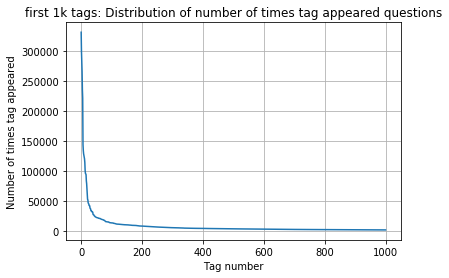

200 [331505 221533 122769  95160  62023  44829  37170  31897  26925  24537
  22429  21820  20957  19758  18905  17728  15533  15097  14884  13703
  13364  13157  12407  11658  11228  11162  10863  10600  10350  10224
  10029   9884   9719   9411   9252   9148   9040   8617   8361   8163
   8054   7867   7702   7564   7274   7151   7052   6847   6656   6553
   6466   6291   6183   6093   5971   5865   5760   5577   5490   5411
   5370   5283   5207   5107   5066   4983   4891   4785   4658   4549
   4526   4487   4429   4335   4310   4281   4239   4228   4195   4159
   4144   4088   4050   4002   3957   3929   3874   3849   3818   3797
   3750   3703   3685   3658   3615   3593   3564   3521   3505   3483
   3453   3427   3396   3363   3326   3299   3272   3232   3196   3168
   3123   3094   3073   3050   3012   2989   2984   2953   2934   2903
   2891   2844   2819   2784   2754   2738   2726   2708   2681   2669
   2647   2621   2604   2594   2556   2527   2510   2482   2460   2444
  

In [21]:
plt.plot(tag_counts[0:1000])
plt.title('first 1k tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()
print(len(tag_counts[0:1000:5]), tag_counts[0:1000:5])

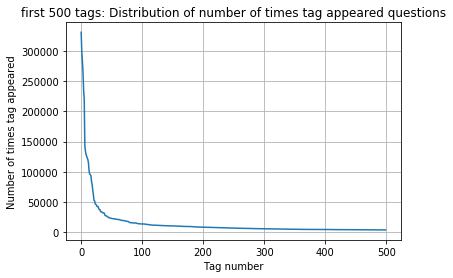

100 [331505 221533 122769  95160  62023  44829  37170  31897  26925  24537
  22429  21820  20957  19758  18905  17728  15533  15097  14884  13703
  13364  13157  12407  11658  11228  11162  10863  10600  10350  10224
  10029   9884   9719   9411   9252   9148   9040   8617   8361   8163
   8054   7867   7702   7564   7274   7151   7052   6847   6656   6553
   6466   6291   6183   6093   5971   5865   5760   5577   5490   5411
   5370   5283   5207   5107   5066   4983   4891   4785   4658   4549
   4526   4487   4429   4335   4310   4281   4239   4228   4195   4159
   4144   4088   4050   4002   3957   3929   3874   3849   3818   3797
   3750   3703   3685   3658   3615   3593   3564   3521   3505   3483]


In [22]:
plt.plot(tag_counts[0:500])
plt.title('first 500 tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()
print(len(tag_counts[0:500:5]), tag_counts[0:500:5])

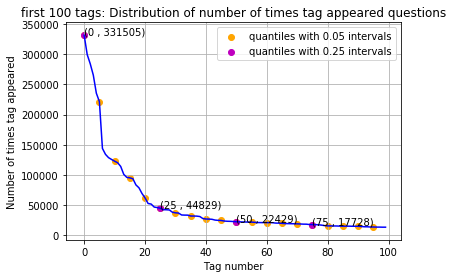

20 [331505 221533 122769  95160  62023  44829  37170  31897  26925  24537
  22429  21820  20957  19758  18905  17728  15533  15097  14884  13703]


In [23]:
plt.plot(tag_counts[0:100], c='b')
plt.scatter(x=list(range(0,100,5)), y=tag_counts[0:100:5], c='orange', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x=list(range(0,100,25)), y=tag_counts[0:100:25], c='m', label = "quantiles with 0.25 intervals")

for x,y in zip(list(range(0,100,25)), tag_counts[0:100:25]):
    plt.annotate(s="({} , {})".format(x,y), xy=(x,y), xytext=(x-0.05, y+500))

plt.title('first 100 tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.legend()
plt.show()
print(len(tag_counts[0:100:5]), tag_counts[0:100:5])

In [24]:
# Store tags greater than 10K in one list
lst_tags_gt_10k = tag_df[tag_df.Counts>10000].Tags
#Print the length of the list
print ('{} Tags are used more than 10000 times'.format(len(lst_tags_gt_10k)))
# Store tags greater than 100K in one list
lst_tags_gt_100k = tag_df[tag_df.Counts>100000].Tags
#Print the length of the list.
print ('{} Tags are used more than 100000 times'.format(len(lst_tags_gt_100k)))

153 Tags are used more than 10000 times
14 Tags are used more than 100000 times


<b>Observations:</b><br />
1. There are total 153 tags which are used more than 10000 times.
2. 14 tags are used more than 100000 times.
3. Most frequent tag (i.e. c#) is used 331505 times.
4. Since some tags occur much more frequenctly than others, Micro-averaged F1-score is the appropriate metric for this probelm.

<h3> 3.3 Tags Per Question </h3>

In [25]:
#Storing the count of tag in each question in list 'tag_count'
tag_quest_count = tag_dtm.sum(axis=1).tolist()
#Converting each value in the 'tag_quest_count' to integer.
tag_quest_count=[int(j) for i in tag_quest_count for j in i]
print ('We have total {} datapoints.'.format(len(tag_quest_count)))

print(tag_quest_count[:5])

We have total 4206314 datapoints.
[3, 4, 2, 2, 3]


In [26]:
print( "Maximum number of tags per question: %d"%max(tag_quest_count))
print( "Minimum number of tags per question: %d"%min(tag_quest_count))
print( "Avg. number of tags per question: %f"% ((sum(tag_quest_count)*1.0)/len(tag_quest_count)))

Maximum number of tags per question: 5
Minimum number of tags per question: 1
Avg. number of tags per question: 2.899440


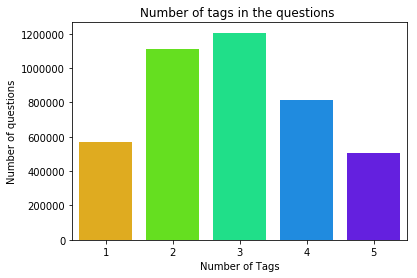

In [27]:
sns.countplot(tag_quest_count, palette='gist_rainbow')
plt.title("Number of tags in the questions ")
plt.xlabel("Number of Tags")
plt.ylabel("Number of questions")
plt.show()

<b>Observations:</b><br />
1. Maximum number of tags per question: 5
2. Minimum number of tags per question: 1
3. Avg. number of tags per question: 2.899
4. Most of the questions are having 2 or 3 tags

<<h3> 3.4 Word cloud Representation of most frequent tags </h3>

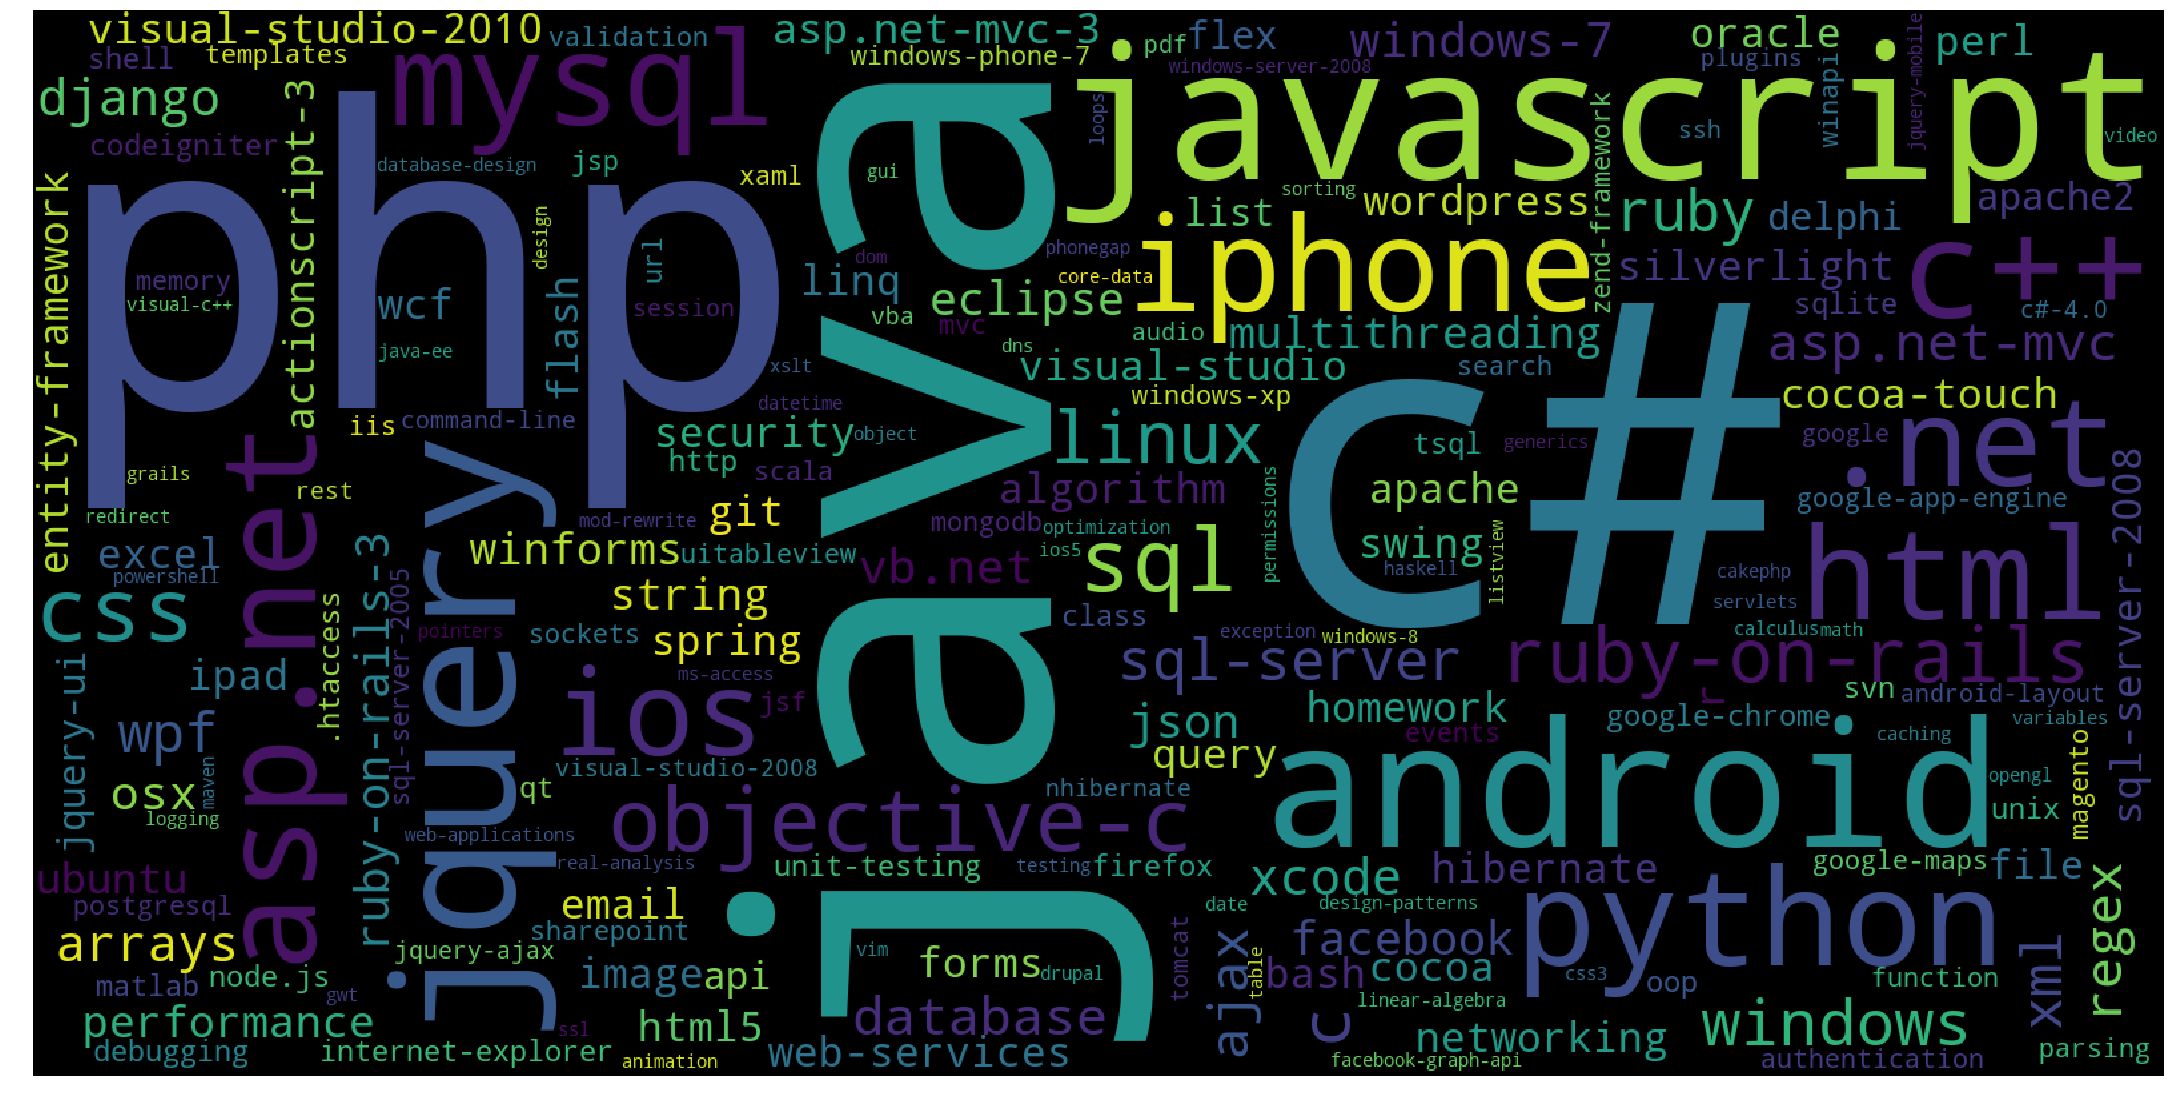

Time taken to run this cell : 0:00:05.470788


In [28]:
# Ploting word cloud
start = datetime.now()

# Lets first convert the 'result' dictionary to 'list of tuples'
tup = dict(result.items())
#Initializing WordCloud using frequencies of tags.
wordcloud = WordCloud(    background_color='black',
                          width=1600,
                          height=800,
                    ).generate_from_frequencies(tup)

fig = plt.figure(figsize=(30,20))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
fig.savefig("tag.png")
plt.show()
print("Time taken to run this cell :", datetime.now() - start)

<b>Observations:</b><br />
A look at the word cloud shows that "c#", "java", "php", "asp.net", "javascript", "c++" are some of the most frequent tags.

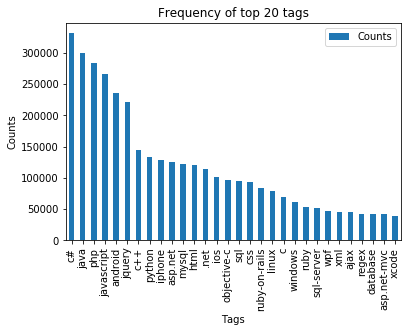

In [29]:
i=np.arange(30)
tag_df_sorted.head(30).plot(kind='bar')
plt.title('Frequency of top 20 tags')
plt.xticks(i, tag_df_sorted['Tags'])
plt.xlabel('Tags')
plt.ylabel('Counts')
plt.show()

<b>Observations:</b><br />
1. Majority of the most frequent tags are programming language.
2. C# is the top most frequent programming language.
3. Android, IOS, Linux and windows are among the top most frequent operating systems.

<h2> 4. Cleaning and preprocessing of Questions </h2>

<h3> 4.1 Text Preprocessing </h3>

<ol> 
    <li> Separate Code from Body </li>
    <li> Remove Spcial characters from Question title and description (not in code)</li>
    <li> <b> Give more weightage to title : Add title three times to the question </b> </li>
   
    <li> Remove stop words (Except 'C') </li>
    <li> Remove HTML Tags </li>
    <li> Convert all the characters into small letters </li>
    <li> Use SnowballStemmer to stem the words </li>
</ol>

**Note** : Here we are taking only 0.5 million data-points and top-500 tags for the exercise

In [30]:
#utility function for cleaning html tags
def striphtml(data):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', str(data))
    return cleantext

#getting the set of stop-words
stop_words = set(stopwords.words('english'))
#using snowballstemer for steeming tht words present in the text
stemmer = SnowballStemmer("english")

### 4.2 Creating New-Database after preprocessing the Data

In [2]:
def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by db_file
    :param db_file: database file
    :return: Connection object or None
    """
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)
 
    return None

def create_table(conn, create_table_sql):
    """ create a table from the create_table_sql statement
    :param conn: Connection object
    :param create_table_sql: a CREATE TABLE statement
    :return:
    """
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)
        
def checkTableExists(dbcon):
    cursr = dbcon.cursor()
    str = "select name from sqlite_master where type='table'"
    table_names = cursr.execute(str)
    print("Tables in the databse:")
    tables =table_names.fetchall() 
    print(tables[0][0])
    return(len(tables))

def create_database_table(database, query):
    conn = create_connection(database)
    if conn is not None:
        create_table(conn, query)
        checkTableExists(conn)
    else:
        print("Error! cannot create the database connection.")
    conn.close()


#creating a new data-base file for pre-processed text
sql_create_table = """CREATE TABLE IF NOT EXISTS QuestionsProcessed (question text NOT NULL, code text, tags text, words_pre integer, words_post integer, is_code integer);"""
create_database_table("Titlemoreweight.db", sql_create_table)

<h2> 4.3 Modeling with less data points (0.5M data points) and more weight to title and 500 tags only. </h2>

In [95]:
#selecting 0.5-million data-points for the excercise
read_db = 'train_no_dup.db'
write_db = 'Titlemoreweight.db'
train_datasize = 400000
if os.path.isfile(read_db):
    conn_r = create_connection(read_db)
    if conn_r is not None:
        reader =conn_r.cursor()
        # for selecting first 0.5M rows
        reader.execute("SELECT Title, Body, Tags From no_dup_train LIMIT 500001;")
        # for selecting random points
        #reader.execute("SELECT Title, Body, Tags From no_dup_train ORDER BY RANDOM() LIMIT 500001;")

if os.path.isfile(write_db):
    conn_w = create_connection(write_db)
    if conn_w is not None:
        tables = checkTableExists(conn_w)
        writer =conn_w.cursor()
        if tables != 0:
            writer.execute("DELETE FROM QuestionsProcessed WHERE 1")
            print("Cleared All the rows")

Tables in the databse:
QuestionsProcessed
Cleared All the rows


In [96]:
start = datetime.now()
preprocessed_data_list=[]
reader.fetchone()
questions_with_code=0
len_pre=0
len_post=0
questions_proccesed = 0
for row in reader:

    is_code = 0

    title, question, tags = row[0], row[1], row[2]

    if '<code>' in question:
        questions_with_code+=1
        is_code = 1
    x = len(question)+len(title)
    len_pre+=x

    code = str(re.findall(r'<code>(.*?)</code>', question, flags=re.DOTALL))

    question=re.sub('<code>(.*?)</code>', '', question, flags=re.MULTILINE|re.DOTALL)
    question=striphtml(question.encode('utf-8'))

    title=title.encode('utf-8')

    question=str(title)+" "+str(question)
    question=re.sub(r'[^A-Za-z]+',' ',question)
    words=word_tokenize(str(question.lower()))

    #Removing all single letter and and stopwords from question exceptt for the letter 'c'
    question=' '.join(str(stemmer.stem(j)) for j in words if j not in stop_words and (len(j)!=1 or j=='c'))

    len_post+=len(question)
    tup = (question,code,tags,x,len(question),is_code)
    questions_proccesed += 1
    writer.execute("insert into QuestionsProcessed(question,code,tags,words_pre,words_post,is_code) values (?,?,?,?,?,?)",tup)
    if (questions_proccesed%100000==0):
        print("number of questions completed=",questions_proccesed)

no_dup_avg_len_pre=(len_pre*1.0)/questions_proccesed
no_dup_avg_len_post=(len_post*1.0)/questions_proccesed

print( "Avg. length of questions(Title+Body) before processing: %d"%no_dup_avg_len_pre)
print( "Avg. length of questions(Title+Body) after processing: %d"%no_dup_avg_len_post)
print ("Percent of questions containing code: %d"%((questions_with_code*100.0)/questions_proccesed))

print("Time taken to run this cell :", datetime.now() - start)

number of questions completed= 100000
number of questions completed= 200000
number of questions completed= 300000
number of questions completed= 400000
number of questions completed= 500000
Avg. length of questions(Title+Body) before processing: 1239
Avg. length of questions(Title+Body) after processing: 424
Percent of questions containing code: 57
Time taken to run this cell : 0:23:12.329039


In [97]:
# dont forget to close the connections, or else you will end up with locks
conn_r.commit()
conn_w.commit()
conn_r.close()
conn_w.close()

__ Sample quesitons after preprocessing of data __

In [98]:
if os.path.isfile(write_db):
    conn_r = create_connection(write_db)
    if conn_r is not None:
        reader =conn_r.cursor()
        reader.execute("SELECT question From QuestionsProcessed LIMIT 10")
        print("Questions after preprocessed")
        print('='*100)
        reader.fetchone()
        for row in reader:
            print(row)
            print('-'*100)
conn_r.commit()
conn_r.close()

Questions after preprocessed
('dynam datagrid bind silverlight dynam datagrid bind silverlight dynam datagrid bind silverlight bind datagrid dynam code wrote code debug code block seem bind correct grid come column form come grid column although necessari bind nthank repli advance..',)
----------------------------------------------------------------------------------------------------
('java.lang.noclassdeffounderror javax servlet jsp tagext taglibraryvalid java.lang.noclassdeffounderror javax servlet jsp tagext taglibraryvalid java.lang.noclassdeffounderror javax servlet jsp tagext taglibraryvalid follow guid link instal jstl got follow error tri launch jsp page java.lang.noclassdeffounderror javax servlet jsp tagext taglibraryvalid taglib declar instal jstl 1.1 tomcat webapp tri project work also tri version 1.2 jstl still messag caus solv',)
----------------------------------------------------------------------------------------------------
('java.sql.sqlexcept microsoft odbc driver

__ Saving Preprocessed data to a Database __

In [3]:
#Taking 0.5 Million entries to a dataframe.
write_db = 'Titlemoreweight.db'
if os.path.isfile(write_db):
    conn_r = create_connection(write_db)
    if conn_r is not None:
        preprocessed_data = pd.read_sql_query("""SELECT question, Tags FROM QuestionsProcessed""", conn_r)
conn_r.commit()
conn_r.close()

In [4]:
preprocessed_data.head()

,question,tags
0,dynam datagrid bind silverlight dynam datagrid...,c# silverlight data-binding
1,dynam datagrid bind silverlight dynam datagrid...,c# silverlight data-binding columns
2,java.lang.noclassdeffounderror javax servlet j...,jsp jstl
3,java.sql.sqlexcept microsoft odbc driver manag...,java jdbc
4,better way updat feed fb php sdk better way up...,facebook api facebook-php-sdk


In [5]:
print("number of data points in sample :", preprocessed_data.shape[0])
print("number of dimensions :", preprocessed_data.shape[1])

number of data points in sample : 500000
number of dimensions : 2


### 4.4 :Converting string Tags to multilable output variables 

<table>
<tr>
<th>X</th><th>y1</th><th>y2</th><th>y3</th><th>y4</th>
</tr>
<tr>
<td>x1</td><td>0</td><td>1</td><td>1</td><td>0</td>
</tr>
<tr>
<td>x1</td><td>1</td><td>0</td><td>0</td><td>0</td>
</tr>
<tr>
<td>x1</td><td>0</td><td>1</td><td>0</td><td>0</td>
</tr>
</table>

In [6]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary='true')
multilabel_y = vectorizer.fit_transform(preprocessed_data['tags'])

In [7]:
def tags_to_choose(n):
    t = multilabel_y.sum(axis=0).tolist()[0]
    sorted_tags_i = sorted(range(len(t)), key=lambda i: t[i], reverse=True)
    multilabel_yn=multilabel_y[:,sorted_tags_i[:n]]
    return multilabel_yn

def questions_explained_fn(n):
    multilabel_yn = tags_to_choose(n)
    x= multilabel_yn.sum(axis=1)
    return (np.count_nonzero(x==0))

__ Selecting 500 Tags __

In [8]:
questions_explained = []
total_tags=multilabel_y.shape[1]
total_qs=preprocessed_data.shape[0]
for i in range(500, total_tags, 100):
    questions_explained.append(np.round(((total_qs-questions_explained_fn(i))/total_qs)*100,3))

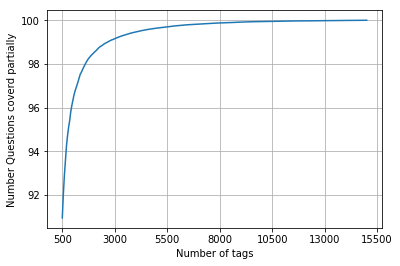

with  5500 tags we are covering  99.157 % of questions
with  500 tags we are covering  90.956 % of questions


In [9]:
fig, ax = plt.subplots()
ax.plot(questions_explained)
xlabel = list(500+np.array(range(-50,450,50))*50)
ax.set_xticklabels(xlabel)
plt.xlabel("Number of tags")
plt.ylabel("Number Questions coverd partially")
plt.grid()
plt.show()
# you can choose any number of tags based on your computing power, minimun is 500(it covers 90% of the tags)
print("with ",5500,"tags we are covering ",questions_explained[50],"% of questions")
print("with ",500,"tags we are covering ",questions_explained[0],"% of questions")

In [10]:
# we will be taking 500 tags
multilabel_yx = tags_to_choose(500)
print("number of questions that are not covered :", questions_explained_fn(500),"out of ", total_qs)

number of questions that are not covered : 45221 out of  500000


In [11]:
print("Number of tags in sample :", multilabel_y.shape[1])
print("number of tags taken :", multilabel_yx.shape[1],"(",(multilabel_yx.shape[1]/multilabel_y.shape[1])*100,"%)")

Number of tags in sample : 29587
number of tags taken : 500 ( 1.6899313887856153 %)


<h1>5. Machine Learning Models </h1>

<h2>5.1 Split the data into test and train (80:20) </h2>

In [12]:
total_size=preprocessed_data.shape[0]
train_size=int(0.80*total_size)

x_train=preprocessed_data.head(train_size)
x_test=preprocessed_data.tail(total_size - train_size)

y_train = multilabel_yx[0:train_size,:]
y_test = multilabel_yx[train_size:total_size,:]

In [13]:
print("Number of data points in train data :", y_train.shape)
print("Number of data points in test data :", y_test.shape)

Number of data points in train data : (400000, 500)
Number of data points in test data : (100000, 500)


## 5.2 Featurizing Data with Bag of words Vectorizer

In [14]:
start = datetime.now()
vectorizer = CountVectorizer(min_df=0.00009, max_features=200000,strip_accents= "unicode",encoding="utf-8",
                               tokenizer = lambda x: x.split(), ngram_range=(1,4))
x_train_multilabel = vectorizer.fit_transform(x_train['question'])
x_test_multilabel = vectorizer.transform(x_test['question'])
features =vectorizer.get_feature_names()
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:05:00.219051


In [15]:
print("Dimensions of train data X:",x_train_multilabel.shape, "Y :",y_train.shape)
print("Dimensions of test data X:",x_test_multilabel.shape,"Y:",y_test.shape)

Dimensions of train data X: (400000, 95585) Y : (400000, 500)
Dimensions of test data X: (100000, 95585) Y: (100000, 500)


In [18]:
accuracy_list = [];
test_error_list = [];
train_error_list = [];
precision_list =[];
recall_list =[];
f1_score_list =[];
hamming_loss_list =[]

#  5.3 Applying Logistic Regression with OneVsRest Classifier 

In [17]:
start = datetime.now()
#initializing the classifier
classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.00001, penalty='l1',n_jobs=-1))
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict (x_test_multilabel)
train_pred = classifier.predict(x_train_multilabel)

#getting the accuracy score
test_acc = accuracy_score(y_test, predictions)*100
print("test accuracy using Logistic-Regression : {0:.2f}%" .format(round(test_acc,2)))  
accuracy_list.append(round(test_acc,2))

#getting the test error
test_error = (100-test_acc)
print("test error using Logistic-Regression  : {0:.2f}%" .format(round(test_error,2)))
test_error_list.append(round(test_error,2))

#getting the train error
train_error =( 1-accuracy_score(y_train,train_pred))*100
print("train error using Logistic-Regression  : {0:.2f}%" .format(round(train_error,2)))
train_error_list.append(round(train_error,2))

#getting the  hamming-loss with logistic-regression
hamming_loss = metrics.hamming_loss(y_test,predictions)
print("Hamming loss using Logistic-Regression:{} ".format(hamming_loss))
hamming_loss_list.append(hamming_loss)

#getting the micro-F1Score of the model
precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
precision_list.append(precision)
recall_list.append(recall)
f1_score_list.append(f1)
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))


#getting the precision,recall,F1-score of each label
print (metrics.classification_report(y_test, predictions))
print("Time taken to run this cell :", datetime.now() - start)

test accuracy using Logistic-Regression : 10.74%
test error using Logistic-Regression  : 89.26%
train error using Logistic-Regression  : 80.03%
Hamming loss using Logistic-Regression:0.00606166 
Micro-average quality numbers
Precision: 0.2826, Recall: 0.4833, F1-measure: 0.3566
              precision    recall  f1-score   support

           0       0.72      0.80      0.75      5519
           1       0.43      0.47      0.45      8190
           2       0.49      0.54      0.51      6529
           3       0.51      0.59      0.55      3231
           4       0.52      0.56      0.54      6430
           5       0.41      0.49      0.45      2879
           6       0.60      0.62      0.61      5086
           7       0.60      0.66      0.63      4533
           8       0.20      0.23      0.21      3000
           9       0.53      0.67      0.60      2765
          10       0.31      0.37      0.34      3051
          11       0.43      0.56      0.48      3009
          12      

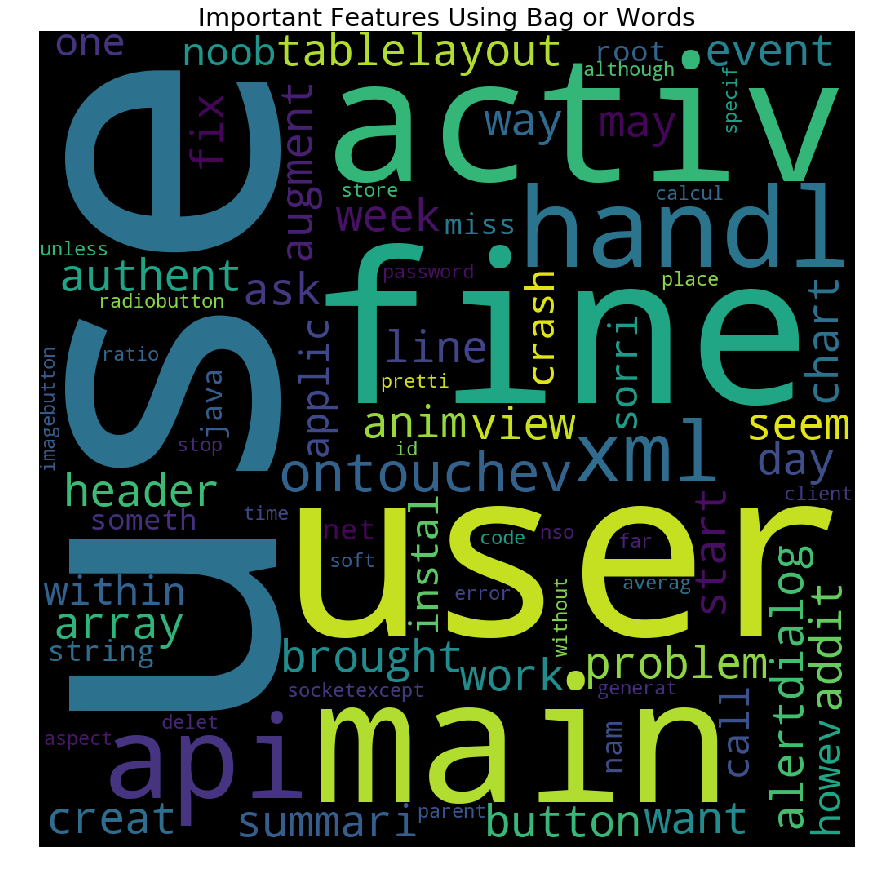

In [18]:
from wordcloud import WordCloud,STOPWORDS
feat_importances = pd.DataFrame(np.column_stack((features,classifier.coef_[0])) )
sort_by_feat_imp = feat_importances.sort_values(1,ascending=False)
top_50 = (sort_by_feat_imp.head(50))
top_50.columns = ["feature" , "value"]
plt.figure(figsize=(15,15))
text = top_50.feature.values
cloud = WordCloud(stopwords=STOPWORDS,background_color='black',collocations=False,width=1000,height=1000
                         ).generate(" ".join(text))
plt.axis('off')
plt.title("Important Features Using Bag or Words",fontsize=25)
plt.imshow(cloud)

#  5.3 Hyperparameter tuning on alpha (or lambda) for Logistic regression to improve the performance

In [22]:
#explicitly giving hyperparameter values for gridsearch and regularization parameters to find best
alpha_values =   [10**-3, 10**-2,10**-1, 10**0, 10,10**2,10**3]
hamming_loss_alpha_list =[]
f1_score_alpha_list =[]
#intializing logistice regression 
for a in alpha_values:
    model1 = OneVsRestClassifier(SGDClassifier(loss='log', alpha=a, penalty='l1',n_jobs=-1))
    model1.fit(x_train_multilabel, y_train)
    predictions1 = model1.predict(x_test_multilabel)
    train_pred1 = model1.predict(x_train_multilabel)
    hamming_loss1 = metrics.hamming_loss(y_test,predictions1)
    hamming_loss_alpha_list.append(hamming_loss1)
    f1_1 = f1_score(y_test, predictions1, average='micro')
    f1_score_alpha_list.append(f1_1)

In [16]:
print("Best alpha value giving giving minimum hamming-loss: {}".format(alpha_values[f1_score_alpha_list[i].index(max(f1_score_alpha_list[i]))]))

Best alpha value giving giving minimum hamming-loss: 0.001


In [19]:
start = datetime.now()
#initializing the classifier
classifier1 = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.001, penalty='l1',n_jobs=-1))
classifier1.fit(x_train_multilabel, y_train)
predictions1 = classifier1.predict (x_test_multilabel)
train_pred1 = classifier1.predict(x_train_multilabel)

#getting the accuracy score
test_acc1 = accuracy_score(y_test, predictions1)*100
print("test accuracy using Logistic-Regression : {0:.2f}%" .format(round(test_acc1,2)))  
accuracy_list.append(round(test_acc1,2))

#getting the test error
test_error1 = (100-test_acc1)
print("test error using Logistic-Regression  : {0:.2f}%" .format(round(test_error1,2)))
test_error_list.append(round(test_error1,2))

#getting the train error
train_error1 =( 1-accuracy_score(y_train,train_pred1))*100
print("train error using Logistic-Regression  : {0:.2f}%" .format(round(train_error1,2)))
train_error_list.append(round(train_error1,2))

#getting the  hamming-loss with logistic-regression
hamming_loss1 = metrics.hamming_loss(y_test,predictions1)
print("Hamming loss using Logistic-Regression:{} ".format(hamming_loss1))
hamming_loss_list.append(hamming_loss1)

#getting the micro-F1Score of the model
precision1 = precision_score(y_test, predictions1, average='micro')
recall1 = recall_score(y_test, predictions1, average='micro')
f1_1 = f1_score(y_test, predictions1, average='micro')
precision_list.append(precision1)
recall_list.append(recall1)
f1_score_list.append(f1_1)
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision1, recall1, f1_1))


#getting the precision,recall,F1-score of each label
print (metrics.classification_report(y_test, predictions1))
print("Time taken to run this cell :", datetime.now() - start)

test accuracy using Logistic-Regression : 18.59%
test error using Logistic-Regression  : 81.41%
train error using Logistic-Regression  : 79.90%
Hamming loss using Logistic-Regression:0.00322414 
Micro-average quality numbers
Precision: 0.5627, Recall: 0.3254, F1-measure: 0.4123
              precision    recall  f1-score   support

           0       0.85      0.64      0.73      5519
           1       0.57      0.19      0.29      8190
           2       0.73      0.36      0.48      6529
           3       0.65      0.47      0.54      3231
           4       0.66      0.45      0.53      6430
           5       0.60      0.42      0.49      2879
           6       0.63      0.58      0.60      5086
           7       0.87      0.56      0.68      4533
           8       0.53      0.14      0.22      3000
           9       0.67      0.56      0.61      2765
          10       0.51      0.19      0.28      3051
          11       0.67      0.37      0.47      3009
          12      

# 5.4 Applying Linear-SVM with OneVsRest Classifier 

In [20]:
start = datetime.now()
#initializing the classifier
classifier2 = OneVsRestClassifier(SGDClassifier(loss='hinge', alpha=0.0001, penalty='l1',n_jobs=-1))
classifier2.fit(x_train_multilabel, y_train)
predictions2 = classifier2.predict (x_test_multilabel)
train_pred2 = classifier2.predict(x_train_multilabel)


#getting the test accuracy
test_acc2 = accuracy_score(y_test, predictions2)*100
print("test accuracy using Linear-SVM : {0:.2f}%" .format(round(test_acc2,2)))  
accuracy_list.append(round(test_acc2,2))

#getting the test error
test_error2 = (100-test_acc2)
print("test error using Linear-SVM  : {0:.2f}%" .format(round(test_error2,2)))
test_error_list.append(round(test_error2,2))

#getting the train error
train_error2 =( 1-accuracy_score(y_train,train_pred2))*100
print("train error using Linear-SVM  : {0:.2f}%" .format(round(train_error2,2)))
train_error_list.append(round(train_error2,2))

#getting the  hamming-loss with logistic-regression
hamming_loss2 = metrics.hamming_loss(y_test,predictions2)
print("Hamming loss using Linear-SVM:{} ".format(hamming_loss2))
hamming_loss_list.append(hamming_loss2)

#getting the micro-F1Score of the model
precision2 = precision_score(y_test, predictions2, average='micro')
recall2 = recall_score(y_test, predictions2, average='micro')
f1_2 = f1_score(y_test, predictions2, average='micro')
precision_list.append(precision2)
recall_list.append(recall2)
f1_score_list.append(f1_2)
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision2, recall2, f1_2))


#getting the precision,recall,F1-score of each label
print (metrics.classification_report(y_test, predictions2))
print("Time taken to run this cell :", datetime.now() - start)

test accuracy using Linear-SVM : 11.90%
test error using Linear-SVM  : 88.10%
train error using Linear-SVM  : 84.32%
Hamming loss using Linear-SVM:0.00450954 
Micro-average quality numbers
Precision: 0.3757, Recall: 0.4490, F1-measure: 0.4091
              precision    recall  f1-score   support

           0       0.68      0.77      0.72      5519
           1       0.43      0.43      0.43      8190
           2       0.54      0.49      0.51      6529
           3       0.46      0.59      0.52      3231
           4       0.56      0.53      0.54      6430
           5       0.44      0.53      0.48      2879
           6       0.56      0.62      0.59      5086
           7       0.59      0.66      0.62      4533
           8       0.25      0.19      0.21      3000
           9       0.52      0.67      0.58      2765
          10       0.40      0.28      0.33      3051
          11       0.49      0.50      0.50      3009
          12       0.40      0.42      0.41      2630


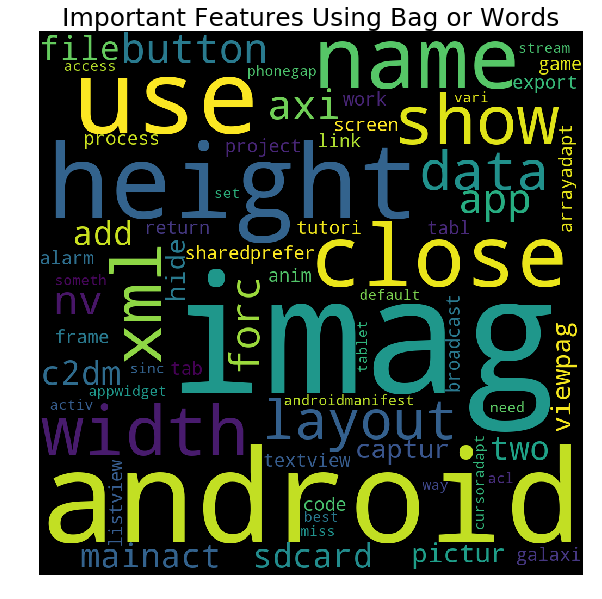

In [21]:
feat_importances = pd.DataFrame(np.column_stack((features,classifier2.coef_[0])) )
sort_by_feat_imp = feat_importances.sort_values(1,ascending=False)
top_50 = (sort_by_feat_imp.head(50))
top_50.columns = ["feature" , "value"]
plt.figure(figsize=(15,15))
text = top_50.feature.values
cloud = WordCloud(stopwords=STOPWORDS,background_color='black',collocations=False,width=1000,height=1000
                         ).generate(" ".join(text))
plt.axis('off')
plt.title("Important Features Using Bag or Words",fontsize=25)
plt.imshow(cloud)

## 6. Conclusions :

In [23]:
#reporting the results in a table
order_list = [0,1,2]
clf_list = ["OvR with Logistic-Regression" , "Logistic-Regression(GridSearch)","OvR with Linear-SVM" ]

for i in order_list:
    t= PrettyTable()
    t.field_names =["metric/Parameter" , "result"]
    t.add_row (["Model" ,"Multi-label Classification"])
    t.add_row (["Classifier" ,clf_list[i]])
    t.add_row(["test accuracy" ,round(accuracy_list[i],2)])
    t.add_row (["Train_error" ,round(train_error_list[i],2)])
    t.add_row (["Test error" , round(test_error_list[i],2)])
    t.add_row (["Hamming-loss" , hamming_loss_list[i]])
    t.add_row (["Precision" , precision_list[i]])
    t.add_row (["Recall" , recall_list[i]])
    t.add_row (["F1-Measure" , f1_score_list[i]])
    print(t)
        

+------------------+------------------------------+
| metric/Parameter |            result            |
+------------------+------------------------------+
|      Model       |  Multi-label Classification  |
|    Classifier    | OvR with Logistic-Regression |
|  test accuracy   |            10.74             |
|   Train_error    |            80.03             |
|    Test error    |            89.26             |
|   Hamming-loss   |          0.0060616           |
|    Precision     |            0.2825            |
|      Recall      |            0.4832            |
|    F1-Measure    |            0.3566            |
+------------------+------------------------------+
+------------------+---------------------------------+
| metric/Parameter |              result             |
+------------------+---------------------------------+
|      Model       |    Multi-label Classification   |
|    Classifier    | Logistic-Regression(GridSearch) |
|  test accuracy   |              18.59          